<a href="https://colab.research.google.com/github/twiesenb/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/Wiesenberg_LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [24]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [25]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [26]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something
import numpy as np
users = []

for _ in range(250):
  # Desktop users
#   time_on_site = random.uniform(10, 600)
  time_on_site = np.random.normal(9.4*60, 3*60)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
#   time_on_site = random.uniform(5, 300)
  time_on_site = np.random.normal(7.5*60, 150)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=529.4902298609317, mobile=True), User(purchased=False, time_on_site=358.6476317499957, mobile=True), User(purchased=True, time_on_site=463.8482121654635, mobile=True), User(purchased=True, time_on_site=519.5595315618755, mobile=True), User(purchased=False, time_on_site=492.1153694013992, mobile=True), User(purchased=False, time_on_site=512.7691230573773, mobile=True), User(purchased=True, time_on_site=351.4602089419168, mobile=True), User(purchased=True, time_on_site=495.9565533161037, mobile=True), User(purchased=False, time_on_site=495.5309303946759, mobile=True), User(purchased=True, time_on_site=460.05987504497995, mobile=True)]


In [27]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,529.490230,True
1,False,358.647632,True
2,True,463.848212,True
3,True,519.559532,True
4,False,492.115369,True


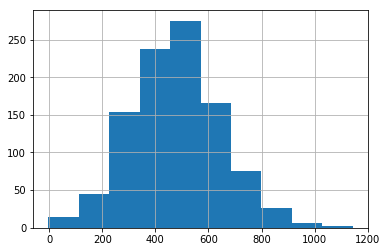

In [28]:
user_data['time_on_site'].hist()
user_data['time_on_site_mins'] = user_data['time_on_site'] /60

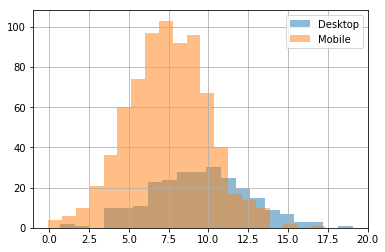

In [29]:
import matplotlib.pyplot as plt
user_data.groupby('mobile')['time_on_site_mins'].hist(bins=20, alpha=0.5)
plt.legend(['Desktop', 'Mobile'])

In [0]:
user_data.loc[user_data['time_on_site'] < 0.0, 'time_on_site'] =0.0

In [31]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,0.0,10.362275708681409,21.516233727332633,37.39419374568752,41.55640873392019,53.52711219994637,60.93905424778683,66.65089996387366,87.76315195673385,97.0486549744981,97.1648648390186,99.02595435979254,99.2036963265387,110.66386635930394,120.0839591192373,122.9860353505361,123.52530893726146,131.6557406174217,134.64935972377117,139.96212156324543,143.60994159237742,147.58333570164604,152.28394982959003,155.86164502389573,156.16758607148682,160.19818358541687,161.0205562173528,161.8471848892279,164.1619330016967,167.5326020676626,171.1457126735067,171.43811115008384,173.80894247152207,174.95053249730142,177.4894868854641,182.32047441918536,185.29741530475184,186.14693314670234,187.46213656423538,189.39673024710788,...,783.9805524860757,785.6981385897491,788.356752466444,788.6350272796267,792.666728912268,796.076075811063,799.7115249903816,800.3561095139369,800.8543953261483,805.5721776426444,807.7616473621674,810.8643399763595,813.8184335131535,815.3139170425957,817.6115026332184,818.3041781391812,829.3043363212889,830.281648292223,830.4189279945722,830.4549860399536,837.8594374768114,839.2579383247601,856.4980077540548,871.0487740417927,876.9795436689963,887.4084800282599,892.8169215545213,896.355445137202,898.3346262716018,901.0411681192734,906.6272323207475,908.5360455697501,934.8251806104453,956.2873043741142,968.5025034807079,996.5006831269886,1004.2895424389712,1017.1539919075661,1039.313226158305,1143.5153550758696
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,1,1,1,1,1,0,1,0,0,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,0,0,1,0,1,0,1,1,0,1,...,0,1,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
True,0,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0,1,0,1,0,0,1,0,...,1,0,1,0,0,0,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,1,1,1,0,1,1,1,1,1,1


In [32]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 3)  # 5 equal-sized bins
pd.crosstab(time_bins, user_data['purchased'])

purchased,False,True
time_on_site,,
"(-1.144, 381.172]",158,127
"(381.172, 762.344]",272,387
"(762.344, 1143.515]",19,37


In [33]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(columns=user_data['purchased'], index=time_bins, normalize='index')

purchased,False,True
time_on_site,,
"(-1.144, 381.172]",0.554386,0.445614
"(381.172, 762.344]",0.412747,0.587253
"(762.344, 1143.515]",0.339286,0.660714


In [34]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.536,0.42
True,0.464,0.58


In [35]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
pd.crosstab(time_bins, [user_data['mobile'], user_data['purchased']], normalize='columns')

mobile                  False               True           
purchased               False     True      False     True 
time_on_site                                               
(-1.144, 381.172]    0.216418  0.077586  0.409524  0.271264
(381.172, 762.344]   0.694030  0.706897  0.568254  0.701149
(762.344, 1143.515]  0.089552  0.215517  0.022222  0.027586

##Stanford Open Policing Project

In [36]:
from google.colab import files
uploaded = files.upload()

In [37]:
df = pd.read_csv('md_statewide_2019_02_25.csv')

FileNotFoundError: ignored

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself
df = pd.read_csv('https://raw.githubusercontent.com/twiesenb/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv', index_col='Unnamed: 0')
print(df.shape)
print(df.dtypes)
df.head()

(1200, 3)
age              int64
weight           int64
exercise_time    int64
dtype: object


,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [39]:
df.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


In [40]:
#splitting attributes into bins
age_bins = pd.cut(df['age'], 3, labels=['low', 'medium', 'high'])
exercise_bins = pd.cut(df['exercise_time'], 3, labels=['low', 'medium', 'high'])
weight_bins = pd.cut(df['weight'], 3, labels=['low', 'medium', 'high'])
#examining exercise time
pd.crosstab(exercise_bins, [age_bins, weight_bins], normalize='columns')

age                 low                      ...      high                    
weight              low    medium      high  ...       low    medium      high
exercise_time                                ...                              
low            0.219828  0.356643  0.823529  ...  0.483660  0.583333  0.901235
medium         0.336207  0.433566  0.176471  ...  0.398693  0.365385  0.098765
high           0.443966  0.209790  0.000000  ...  0.117647  0.051282  0.000000

[3 rows x 9 columns]

From the crosstab above, we can see that as weight increases, exercise time decreases. One weakness to the data in drawing this conclusion, however, is that the data is not measured over time, because the data is not tracking weight loss journeys, but an instance in time.

Again, I think time is a confounding variable in the effect of age on exercise time. In this dataset, we don't know which individiuals have made a habit of exercise over time.

In [41]:
#examining weight
pd.crosstab(weight_bins, [age_bins, exercise_bins], normalize='columns')

age                 low                      ...      high                    
exercise_time       low    medium      high  ...       low    medium      high
weight                                       ...                              
low            0.354167  0.523490  0.774436  ...  0.310924  0.484127  0.692308
medium         0.354167  0.416107  0.225564  ...  0.382353  0.452381  0.307692
high           0.291667  0.060403  0.000000  ...  0.306723  0.063492  0.000000

[3 rows x 9 columns]

In [42]:
pd.crosstab(age_bins, [weight_bins, exercise_bins], normalize='columns')

weight             low                      ...   medium      high          
exercise_time      low    medium      high  ...     high       low    medium
age                                         ...                             
low            0.31875  0.408377  0.417004  ...  0.46875  0.274510  0.321429
medium         0.21875  0.272251  0.510121  ...  0.40625  0.248366  0.392857
high           0.46250  0.319372  0.072874  ...  0.12500  0.477124  0.285714

[3 rows x 8 columns]

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
Age and weight are discrete variables (only because they are ints in the data), while exercise time is continuous.
2.  What are the relationships between the variables?
As age increases: exercise decreases and weight stays the same.
As weight increases: exercise decreases and age stays the same.
As exercise time increases: weight decreases and age decreases.
3.  Which relationships are "real", and which spurious?
I think the relationship between age and weight is accurate, but only because in the data the youngest person is 18. If the ages began at birth, causation would be inaccurate. Also, any relationship where age is the dependent variable is inaccruate because the only variable that affects age is time. I think for the relationships between weight and exercise time, the confouding variable is time, because the data does not track the indviduals' weight loss journeys over time, but rather tracks different indviduals at one point in time. For the relationship between age and exercise time, I think a confouding factor is employment, or amount of free time during the day. 



## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)